In [1]:
# Martin Leonardo Aritonang
# 10219092
# melakukan prediksi perkiraan harga rumah dengan teknik regresi lanjutan

## 1. Import library dan data

In [2]:
#import library yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data train dan test

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [4]:
train_df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [5]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 2. Visualisasi data

**Sebelum melakukan preprocessing data, kita harus melakukan visualisasi data terlebih dahulu untuk melihat korelasi antar data dan lainnya sehingga nantinya memudahkan kita untuk melakukan preprocessing data.
Target kita yaitu SalePrice maka kita coba lihat distribusinya**

<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

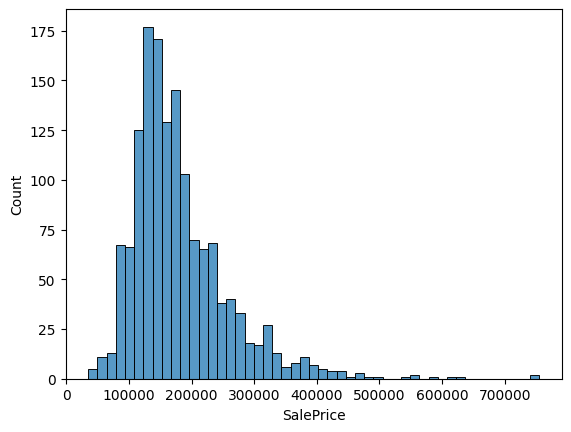

In [6]:
sns.histplot(train_df['SalePrice'])

Dari grafik dapat dilihat pada distribusi SalePrice yaitu right-skewned atau positive-skewned

**Sekarang kita coba lihat korelasi antar kolom**

<AxesSubplot: >

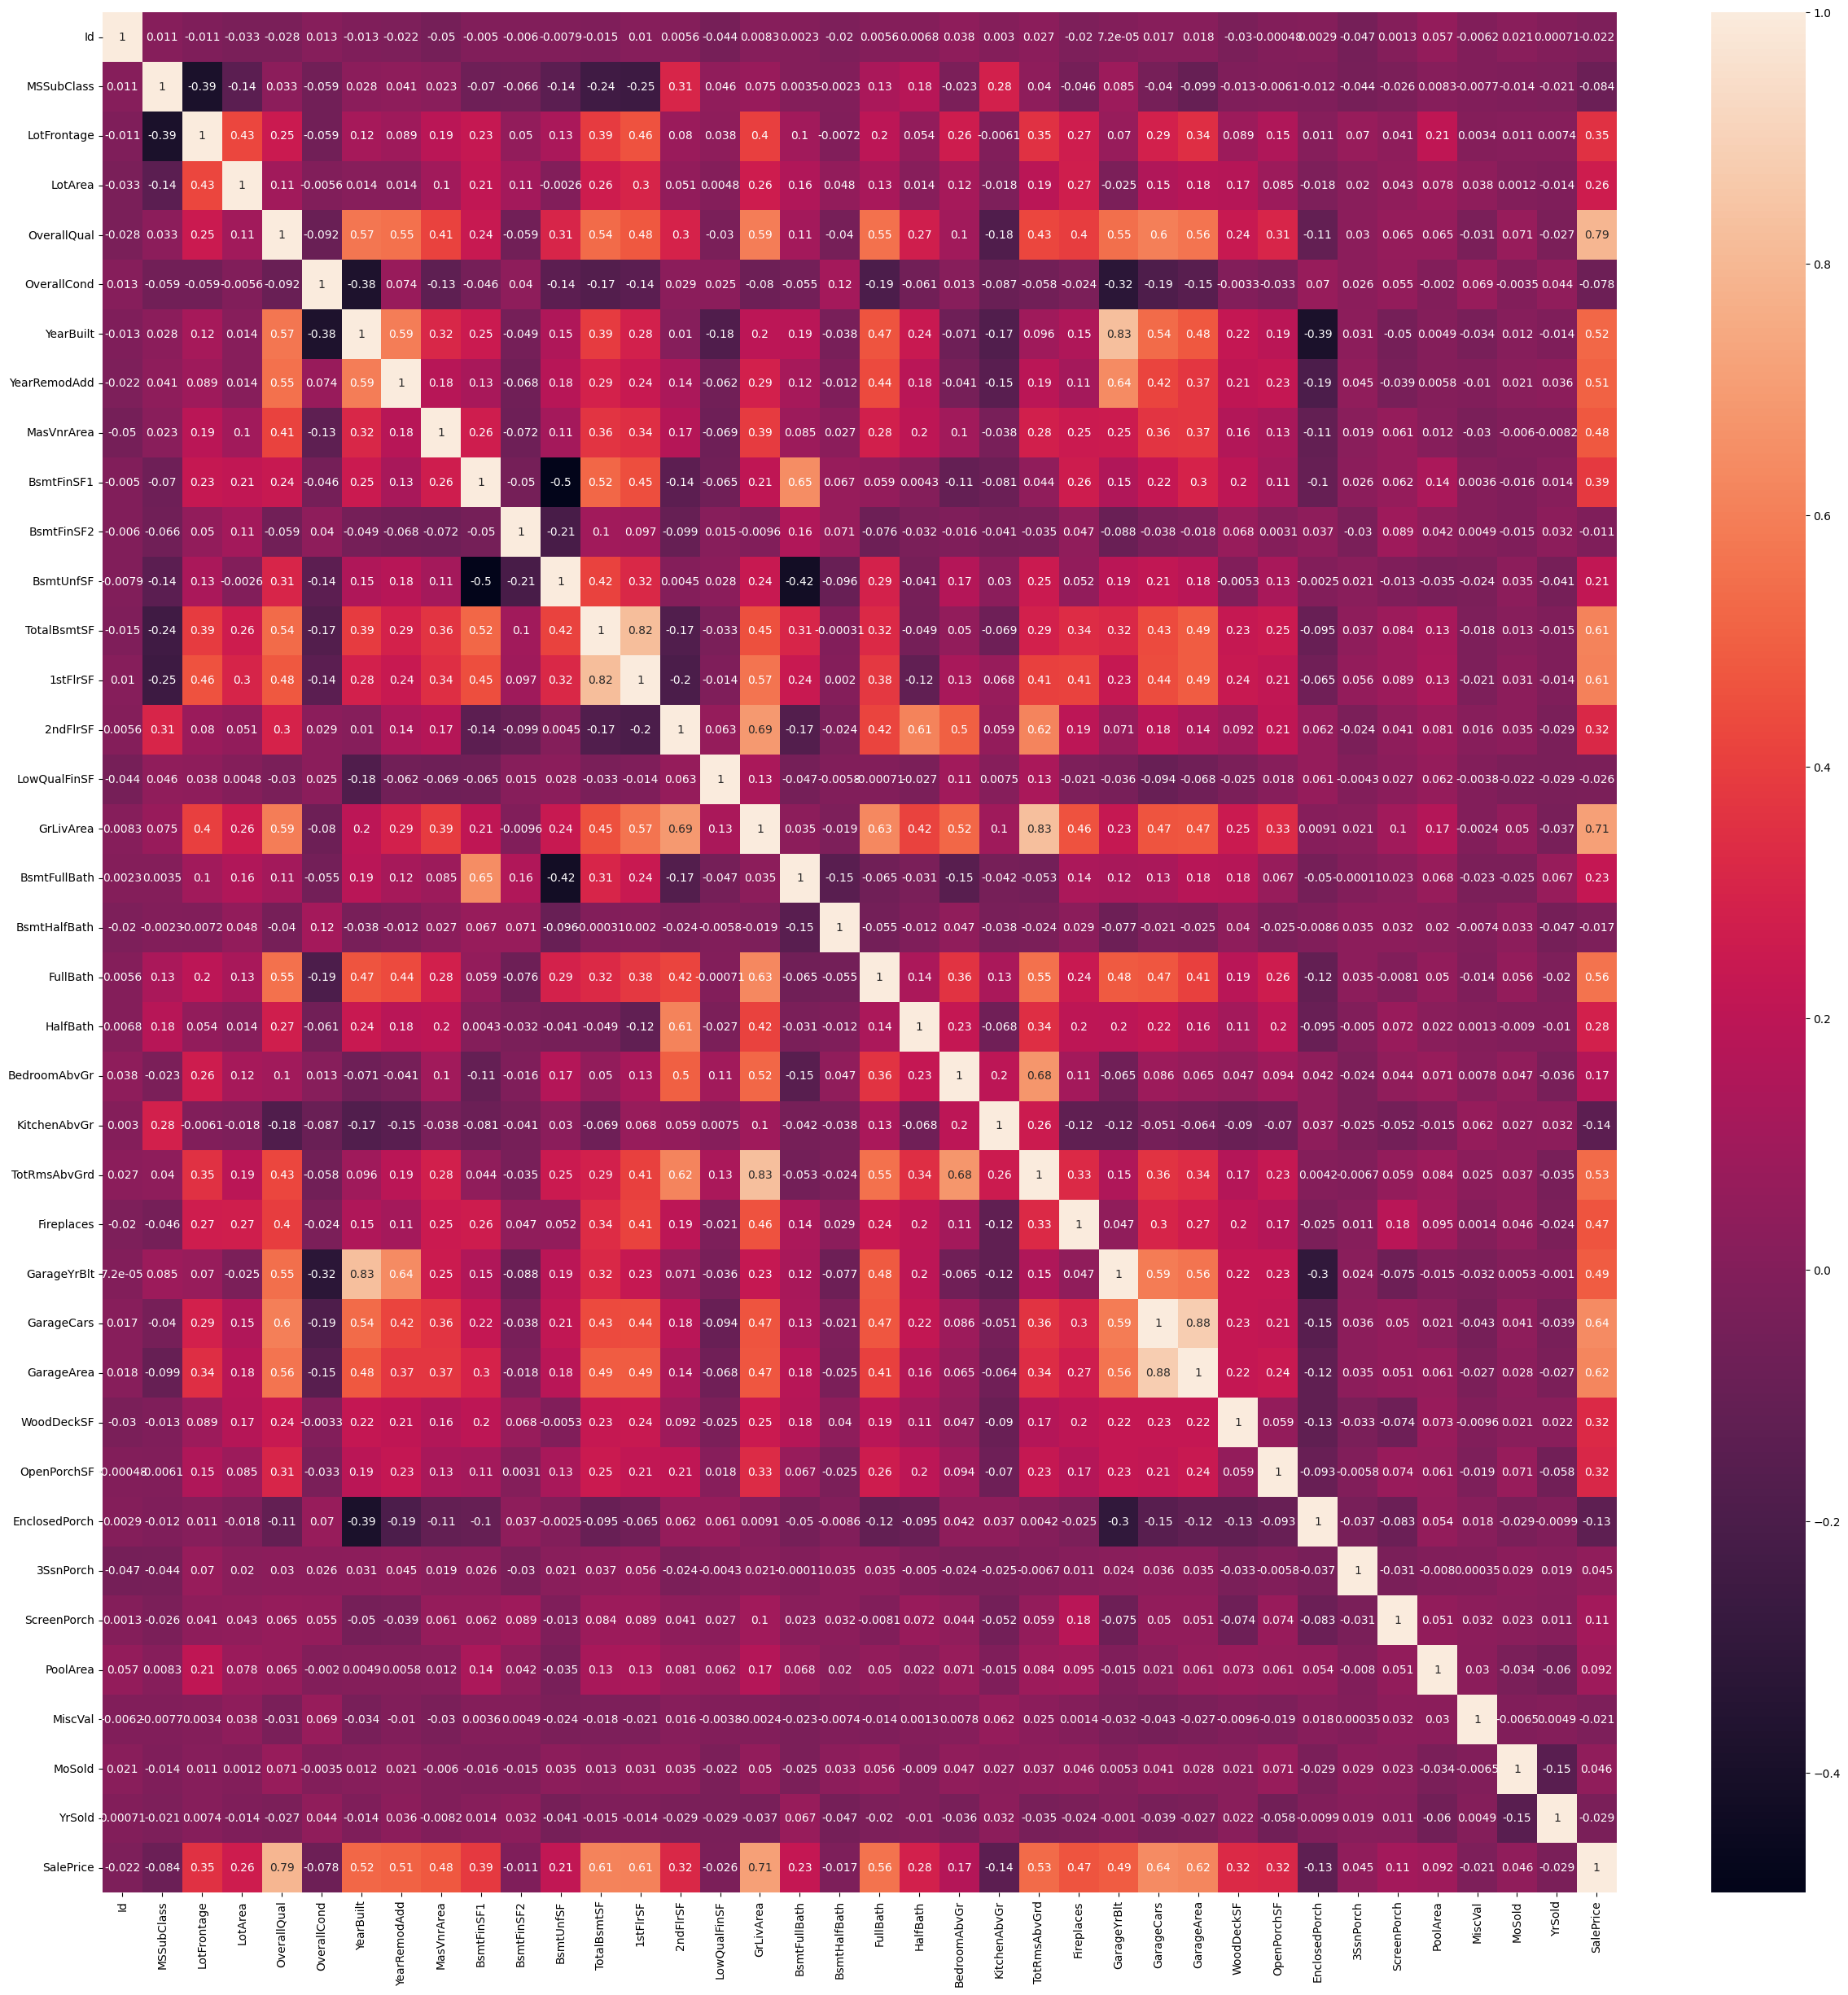

In [7]:
train_df_corr = train_df.corr(numeric_only = True)
plt.figure(figsize=(30,30))
sns.heatmap(train_df_corr,annot=True)

**Karena sangat banyak variabel yang mempengaruhi SalePrice, kita coba petakan kedalam heatmap variabel apa saja yang memiliki korelasi lebih besar dari 0.5 terhadap SalePrice agar memudahkan visualisasi kita**

<AxesSubplot: >

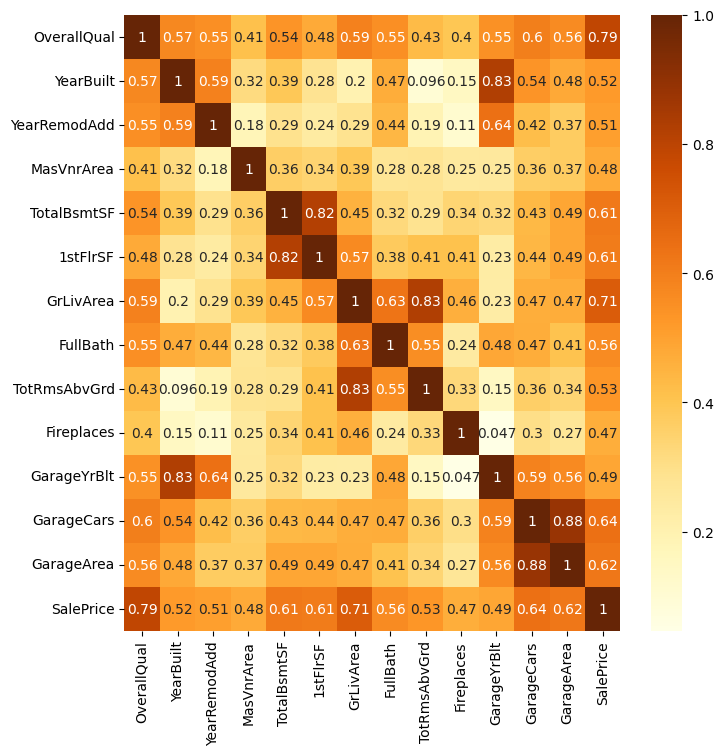

In [8]:
index_highest_corr = train_df_corr.index[train_df_corr['SalePrice']>0.45]
plt.figure(figsize=(8,8))
sns.heatmap(train_df[index_highest_corr].corr(),annot = True, cmap='YlOrBr')

<AxesSubplot: >

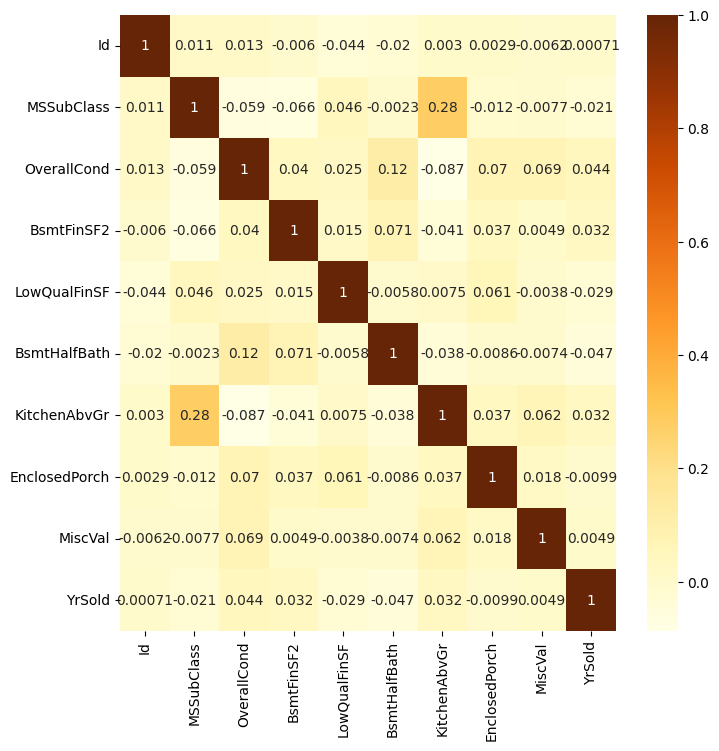

In [9]:
index_highest_corr = train_df_corr.index[train_df_corr['SalePrice'] < 0]
plt.figure(figsize=(8,8))
sns.heatmap(train_df[index_highest_corr].corr(),annot = True, cmap='YlOrBr')

**Kita coba plot feature yang memiliki korelasi besar terhadap SalePrice**

Text(0.5, 1.0, 'Distribusi SalePrice terhadap OverallQual')

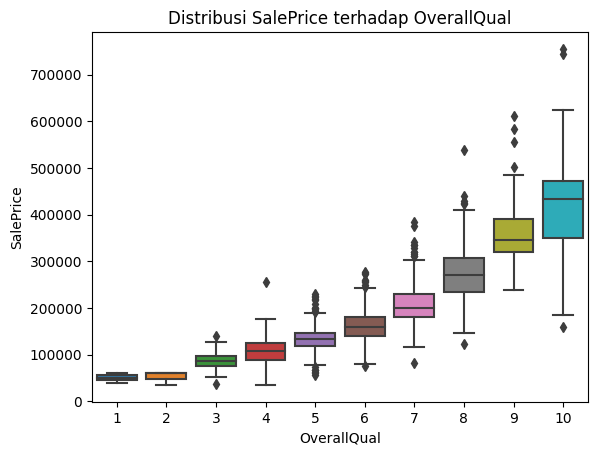

In [10]:
sns.boxplot(data = train_df,x='OverallQual' , y = 'SalePrice')
plt.title('Distribusi SalePrice terhadap OverallQual')

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

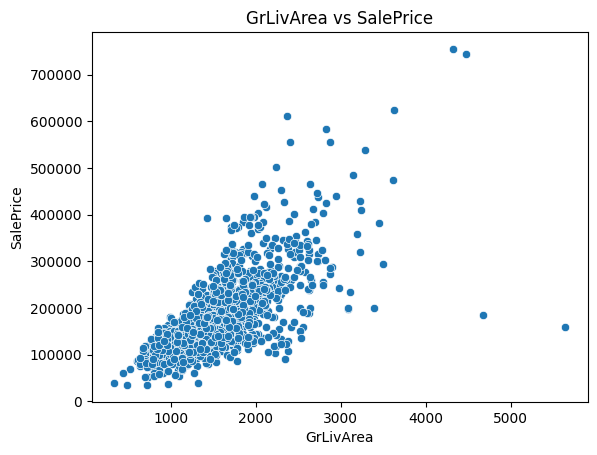

In [11]:
sns.scatterplot(data =train_df,x='GrLivArea',y = 'SalePrice')
plt.title('GrLivArea vs SalePrice')

Text(0.5, 1.0, 'Distribusi SalePrice terhdap GarageCars')

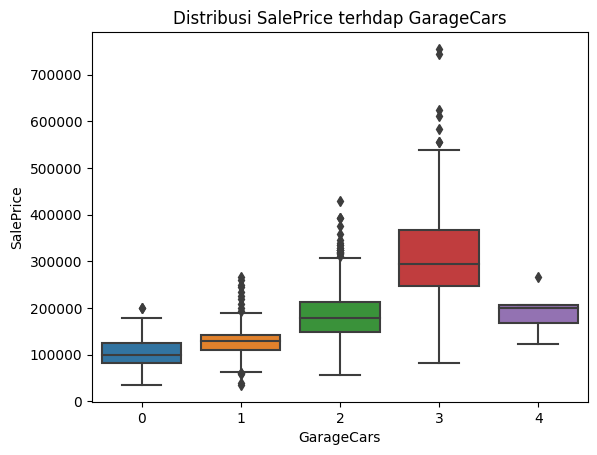

In [12]:
sns.boxplot(data =train_df,x='GarageCars',y = 'SalePrice')
plt.title('Distribusi SalePrice terhdap GarageCars')

Text(0.5, 1.0, 'GarageRea vs SalePrice')

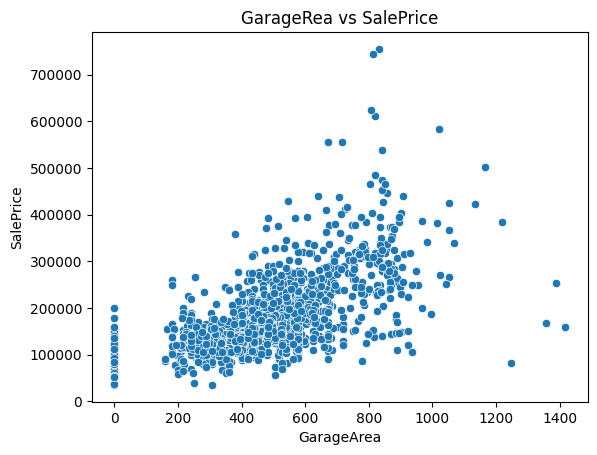

In [13]:
sns.scatterplot(data = train_df, x = 'GarageArea', y = 'SalePrice')
plt.title('GarageRea vs SalePrice')

**Dari heatmap dapat kita simpulkan**
* Korelasi terbesar terhadap SalePrice yaitu dimiliki oleh OverallQual sebesar 0.79
* Tidak ada yang membuat harga dari suatu rumah turun atau berkorelasi negatif dengannya


## 3. Preprocessing Data

In [14]:
#cek data apakah ada data null pada train dan test
#untuk data train
train_df.isnull().sum().sort_values(ascending=False).head(25)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
Functional         0
Fireplaces         0
KitchenQual        0
KitchenAbvGr       0
BedroomAbvGr       0
dtype: int64

In [15]:
test_df.isnull().sum().sort_values(ascending=False).head(25)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
BsmtFinSF2         1
dtype: int64

**Karena di kedua dataframe terdapat null, untuk memudahkan kita lakukan saja concat untuk membersihkan data secara bersamaan**

In [16]:
y_train = train_df['SalePrice']
test_df_id = test_df['Id']
all_data = pd.concat([train_df,test_df])
all_data = all_data.drop(['Id','SalePrice'], axis ='columns')

merged = all_data.copy()
print(merged.shape)

(2919, 79)


In [17]:
# cek apakah ada data null pada train dan test
null_sum = merged.isnull().sum().sort_values(ascending=False)
null_percent = (merged.isnull().sum()/merged.isnull().shape[0]*100).sort_values(ascending=False)
null_total = pd.concat([null_sum, null_percent], axis = 1, keys=['null_sum','null_percentage'])
null_total.head(25)

,null_sum,null_percentage
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071


**Kita drop features yang mempunyai null lebih besar dari 50**

In [18]:
x = merged.drop((null_total[null_total['null_sum']>50]).index, axis = 'columns', inplace = False)
print(x.isnull().sum().sort_values(ascending=False).head(25))

MasVnrType      24
MasVnrArea      23
MSZoning         4
BsmtFullBath     2
BsmtHalfBath     2
Utilities        2
Functional       2
GarageArea       1
Exterior2nd      1
Exterior1st      1
KitchenQual      1
GarageCars       1
BsmtFinSF2       1
BsmtFinSF1       1
BsmtUnfSF        1
TotalBsmtSF      1
Electrical       1
SaleType         1
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
FullBath         0
MSSubClass       0
TotRmsAbvGrd     0
LowQualFinSF     0
dtype: int64


In [19]:
x[['MasVnrType','MasVnrArea','MSZoning','BsmtFullBath','BsmtHalfBath','Utilities','Functional','GarageArea','Exterior2nd','Exterior1st','KitchenQual','GarageCars','BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','Electrical','SaleType']].dtypes

MasVnrType       object
MasVnrArea      float64
MSZoning         object
BsmtFullBath    float64
BsmtHalfBath    float64
Utilities        object
Functional       object
GarageArea      float64
Exterior2nd      object
Exterior1st      object
KitchenQual      object
GarageCars      float64
BsmtFinSF2      float64
BsmtFinSF1      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
Electrical       object
SaleType         object
dtype: object

Pisahkan data null untuk numerik dan kategorik

In [20]:
numerik = ['MasVnrArea','BsmtFullBath','BsmtHalfBath','GarageArea','GarageCars','BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF']
kategorik = ['MasVnrType','MSZoning','Utilities','Functional','Exterior2nd','Exterior1st','KitchenQual','Electrical','SaleType']

### mengisi data null

In [21]:
# data numerik
for i in numerik :
    x[i] = x[i].fillna(x[i].median())

In [22]:
# data kategorik
for i in kategorik:
    x[i] = x[i].fillna(x[i].mode()[0])

In [23]:
# sekarang cek ulang apakah ada data null
x.isnull().values.any()

False

### Setelah tidak ada lagi data null, ubah data kategorik menjadi numerik

In [24]:
x = pd.get_dummies(x)
x.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


### Pisahkan data train dan test

In [25]:
print(len(y_train))
x_train = x[:len(y_train)]
print('x_train shape :',x_train.shape)
x_test = x[len(y_train):]
print('x_test shape :',x_test.shape)

1460
x_train shape : (1460, 225)
x_test shape : (1459, 225)


## 4. Lakukan standarisasi data

In [26]:
#standarisasi x_train dan x_test
scaler = StandardScaler()
scaler.fit(x_train)
x_train_standarization = scaler.transform(x_train)
x_test_standarization = scaler.transform(x_test)

## 5. Modelkan menggunakan Machine Learning

In [27]:
model = XGBRegressor()
model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [28]:
y_predict = model.predict(x_test)

In [29]:
sub = pd.DataFrame()
sub['Id'] = test_df_id
sub['SalePrice'] = y_predict
sub.to_csv('Martin House Price Advance Regression.csv',index=False)